# Treino do modelo para filtro <a name="reino"></a>

In [1]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

from keras.preprocessing import image as kimage
import glob

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2 
from skimage.transform import resize
import os

import tensorflow as tf
from tensorflow.keras import models, layers, datasets, utils, preprocessing, Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Error Level Analysis

In [3]:
# Error Level Analysis
def convert_to_ela_image(path, quality):
    filename = path
    
    # criar uma imagem jpg com o nome resaved    
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    
    # gravar um nova imagem png como ela
    #ELA_filename = filename.split('.')[0] + '.ela.png'
    
    # converter a imagem inicial para RGB(sistema de cores em que o vermelho, verde e azul são combinados)
    im = Image.open(filename).convert('RGB')
    
    # gravar a imagem resaved com o formato JPEG
    im.save(resaved_filename, 'JPEG', quality=quality)
    
    # abrir a imagem gravada como resaved
    resaved_im = Image.open(resaved_filename)
    
    # retorna uma imagem resultante da diferenca entre os pixeis da imagem resaved e a imagem inicial
    # caso a imagem seja alterada irá ter zonas com niveis de compressão diferentes resultantes da imagem resaved e outras
    # zonas com os niveis de compressão da imagem original.
    ela_im = ImageChops.difference(im, resaved_im)
    
    # retorna o valor máximo e minimo do valor rgb de cada pixel
    # quando não há alterações esses valores são zero
    # quando existem são diferentes de zero e quanto maior o valor máximo maior é a alteração
    extrema = ela_im.getextrema()
    
    # retorna o valor máximo do valor de rgb de cada pixel
    max_diff = max([ex[1] for ex in extrema])
    
    # Se o valor máximo for 0==1 para se poder fazer a divisão
    # caso contário dividir o valor máximo do pixel(255) por o valor máximo de rgb
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    # Quando a imagem é verdadeira o scale é indiferente porque não existem zonas a ser realçadas
    # Quando a imagem é falsa realca os pixeis alterados consoante a escala. Alterações feitas a preto são mais realçadas
    # o que alterações feitas com outras cores
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    
    return ela_im

In [4]:
#filename = 'ela_real_and_fake/real/person_0001.jpg'
filename = 'ela_real_and_fake/fake/person_0005_mod.jpg'
resaved_filename = filename.split('.')[0] + '.resaved.jpg'
im = Image.open(filename).convert('RGB')
im.save(resaved_filename, 'JPEG', quality=90)
resaved_im = Image.open(resaved_filename)

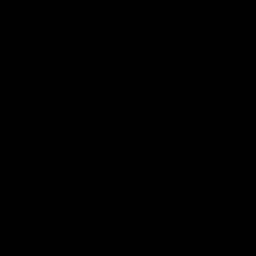

In [5]:
ela_im = ImageChops.difference(im, resaved_im)
ela_im

In [6]:
extrema = ela_im.getextrema()
extrema

((0, 4), (0, 9), (0, 9))

In [7]:
max_diff = max([ex[1] for ex in extrema])
max_diff

9

In [8]:
if max_diff == 0:
        max_diff = 1
scale = 255.0 / max_diff

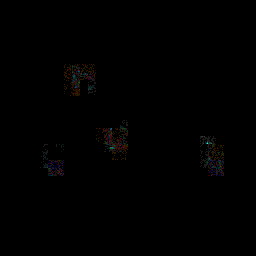

In [9]:
ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
ela_im

### Dados

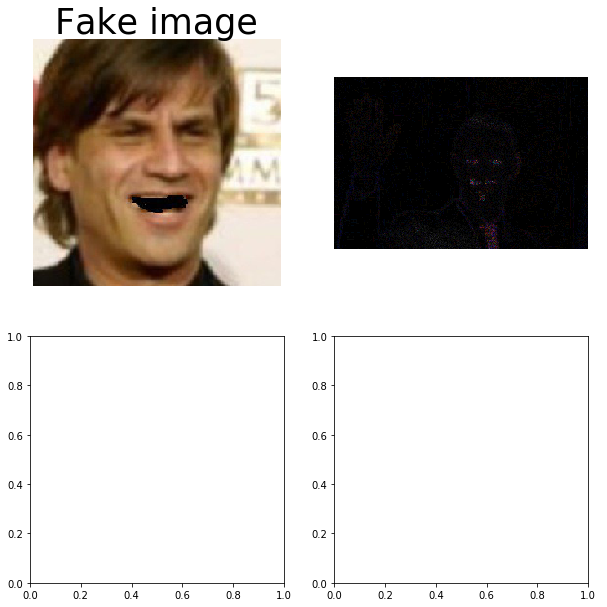

In [71]:
#image_fake = kimage.load_img(np.random.choice(glob.glob('ela_real_and_fake/fake/person_0000_mod.jpg')), target_size=(200, 200))
#image_fake_ela = convert_to_ela_image('ela_real_and_fake/fake/person_0000_mod.jpg', 90)
#image_real = kimage.load_img(np.random.choice(glob.glob('ela_real_and_fake/real/person_0000.jpg')), target_size=(200, 200))
#image_real_ela = convert_to_ela_image('ela_real_and_fake/real/person_0000.jpg', 90)
#image_fake = kimage.load_img(np.random.choice(glob.glob('ela_real_and_fake/fake/person_0010_mod.jpg')), target_size=(200, 200))
#image_fake_ela = convert_to_ela_image('ela_real_and_fake/fake/person_0010_mod.jpg', 90)
#image_fake_ela = convert_to_ela_image('Nova Pasta/101.jpg', 90)
image_fake_ela = convert_to_ela_image('Nova Pasta/101_mod.jpg', 90)

fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax[0,0].set_title("Fake image",size=35)
ax[0,0].imshow(image_fake)
ax[0,0].axis('off')
ax[0,1].imshow(image_fake_ela)
ax[0,1].axis('off')
#ax[1,0].set_title("Real image",size=35)
#ax[1,0].imshow(image_real)
#ax[1,0].axis('off')
#ax[1,1].imshow(image_real_ela)
#ax[1,1].axis('off')

plt.show()

### Transformar os dados num vector em que o tensorflow consiga fazer a sua leitura.

In [11]:
classes=[]
directory=os.listdir('ela_real_and_fake')
for i in range(len(directory)):
    classes.append(os.listdir('ela_real_and_fake')[i])
print(classes)

['fake', 'real']


In [12]:
num_img=[]
for i in range(len(classes)):      
    num_img_classes=len(os.listdir('ela_real_and_fake/'+classes[i]))
    num_img.append(num_img_classes)
print(num_img)

[68, 56]


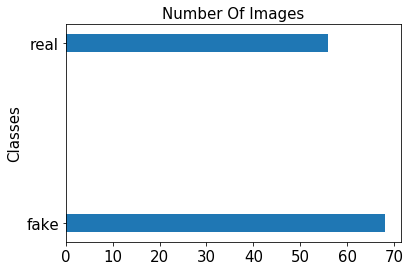

In [13]:
plt.figure(figsize=(6,4))

plt.barh(classes,num_img, align='center',height=0.1)
plt.title('Number Of Images', size=15)
plt.xlabel('', size=15)
plt.xticks(size=15)
plt.ylabel('Classes', size=15)
plt.yticks(size=15)
plt.show()

In [14]:
x_fake= []
y_fake = []
for img in glob.glob("ela_real_and_fake/fake/*.jpg"):
    if img[-11:] != "resaved.jpg" : 
        x_fake.append(array(convert_to_ela_image(img, 90).resize((100, 100))).flatten())
        y_fake.append(classes[0])

In [15]:
len(x_fake)

34

In [16]:
x_real= []
y_real = []
for img in glob.glob("ela_real_and_fake/real/*.jpg"):
     if img[-11:] != "resaved.jpg" : 
        x_real.append(array(convert_to_ela_image(img, 90).resize((100, 100))).flatten())
        y_real.append(classes[1])

In [17]:
len(x_real)

28

In [18]:
x_classes=x_fake+x_real
y_classes=y_fake+y_real

x_classes=np.array(x_classes)
y_classes=np.array(y_classes)

x_classes = x_classes.reshape(-1, 100, 100, 3)

print(x_classes.shape)
print(y_classes.shape)

(62, 100, 100, 3)
(62,)


### Transformação de variaveis em dummys

In [19]:
y_categorical = LabelEncoder().fit_transform(y_classes)
y_classes = utils.to_categorical(y_categorical)
print(y_classes.shape)

(62, 2)


### Alterar a distribuição dos dados

In [20]:
index = np.arange(x_classes.shape[0])

In [21]:
np.random.seed(100)
np.random.shuffle(index)

In [22]:
X = x_classes[index]
Y = y_classes[index]

### Divisão treino-teste

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

### Modelo CNN

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), input_shape=(100, 100, 3), activation="relu")) 
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(32, (3,3), activation="relu")) 
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Conv2D(64, (3,3), activation="relu")) 
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Conv2D(128, (3,3), activation="relu")) 
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(units=128, activation="relu")) 
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units=128, activation="relu")) 
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units=2, activation="softmax")) 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Compilação e Ajuste do modelo CNN

In [25]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
model.fit(X, Y,batch_size=2, epochs=10)

Epoch 1/10
62/62 [==============================] - 3s 56ms/sample - loss: 1.3259 - acc: 0.8065
Epoch 2/10
62/62 [==============================] - 1s 19ms/sample - loss: 0.4772 - acc: 0.9032
Epoch 3/10
62/62 [==============================] - 1s 21ms/sample - loss: 0.1816 - acc: 0.9677
Epoch 4/10
62/62 [==============================] - 1s 19ms/sample - loss: 0.1264 - acc: 0.9677
Epoch 5/10
62/62 [==============================] - 1s 19ms/sample - loss: 0.1193 - acc: 0.9677
Epoch 6/10
62/62 [==============================] - 1s 19ms/sample - loss: 0.3080 - acc: 0.9516
Epoch 7/10
62/62 [==============================] - 1s 19ms/sample - loss: 0.1338 - acc: 0.9677
Epoch 8/10
62/62 [==============================] - 1s 19ms/sample - loss: 0.1706 - acc: 0.9355
Epoch 9/10
62/62 [==============================] - 1s 19ms/sample - loss: 0.1150 - acc: 0.9677
Epoch 10/10
62/62 [==============================] - 1s 20ms/sample - loss: 0.1234 - acc: 0.9677


### Previsão e Avaliação do Modelo CNN

In [27]:
predictions = model.predict(X)
predictions[1]

array([1.000000e+00, 3.431006e-14], dtype=float32)

In [28]:
predictions_index = [np.argmax(index) for index in np.array(predictions)]

In [29]:
y_test_index = [np.argmax(index) for index in np.array(Y)]

In [30]:
pd.DataFrame({"prediction index": predictions_index, "teste index":y_test_index}).head(5)

,prediction index,teste index
0,1,0
1,0,0
2,1,1
3,0,0
4,1,1


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
print(classification_report(y_test_index, predictions_index))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.93      1.00      0.97        28

   micro avg       0.97      0.97      0.97        62
   macro avg       0.97      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62



In [33]:
confusion = confusion_matrix(y_test_index,predictions_index)

In [34]:
outside_columns = ["Predicted",""]
outside_index = ["Actual",""]
inside = ["fake","real"]

hier_columns = list(zip(outside_columns, inside))
hier_columns = pd.MultiIndex.from_tuples(hier_columns)

hier_index = list(zip(outside_index, inside))
hier_index = pd.MultiIndex.from_tuples(hier_index)

pd.DataFrame(confusion, columns=hier_columns, index = hier_index)

,,Predicted,
,,fake,real
Actual,fake,32,2
,real,0,28


### Previsão de uma imagem

In [63]:
#image='ela_real_and_fake/real/person_0000.jpg'
#image='ela_real_and_fake/fake/person_0000_mod.jpg'

image='Nova Pasta/101.resaved.jpg'

image_array=array(convert_to_ela_image(image, 90).resize((100, 100))).flatten()
image_final = image_array.reshape(1, 100, 100, 3)

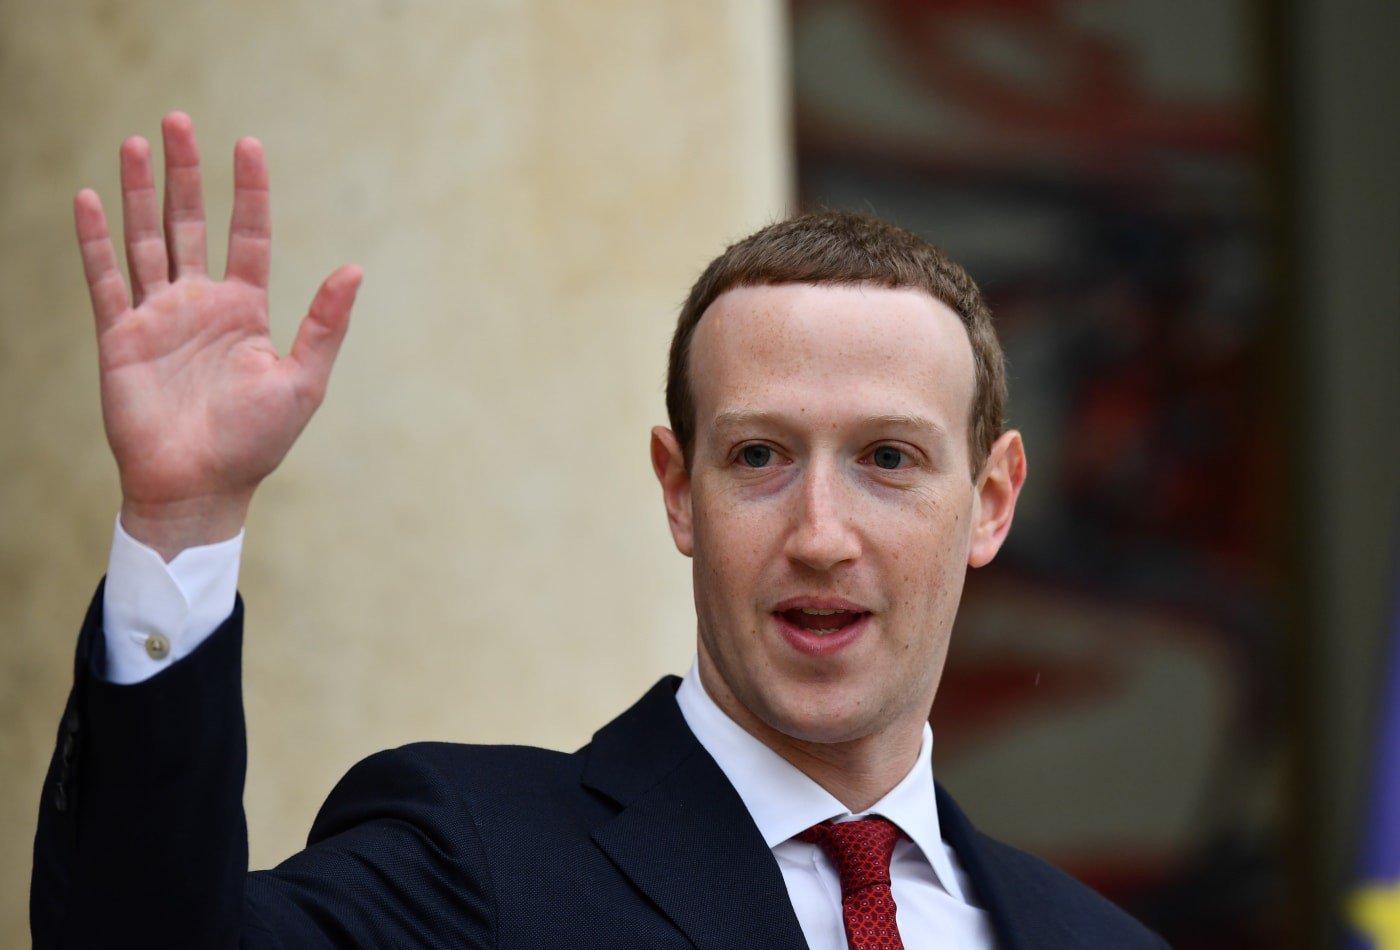

In [64]:
Image.open(image)

In [65]:
result = model.predict(image_final)
result.argmax()
result

array([[0.9983053 , 0.00169468]], dtype=float32)

In [66]:
def prediction():
    if result.argmax() == 0:
        print("Fake")
    if result.argmax() == 1:
        print("Real")

In [67]:
prediction()

Fake


### Gravar o modelo

In [34]:
model_json = model.to_json()

In [35]:
# gravar o modelo no formato json
with open('model_filter.json', 'w') as json_file:
    json_file.write(model_json)

In [36]:
# gravar os pesos no formato h5
model.save_weights('model_filter_weights.h5')

In [37]:
# gravar o modelo no formato h5
model.save('model_filter.h5')